<a href="https://colab.research.google.com/github/alesanchez14/A-B-testing-using-Machine-Learning/blob/main/A_B_Testing_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A/B Testing using Machine Learning**

Get a Step-by-Step Walkthrough for implementing machine learning for A/B

Testing in Python using 3 different algorithms:
- Linear Regression
- Decision Trees
- XGBoost

Develop a Story for what contributes to the goal of gaining Enrollments

Get a Learning Recommendation for those that want to learn how to implement machine learning following best practices for any business problem.


### **Task 1 - Loading our data**

Importing Modules

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning: model building, evaluation, and preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.utils import shuffle

# XGBoost for modeling and plotting
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

# Statistical modeling
import statsmodels.api as sm


Loading our data

In [ ]:
control_tbl = pd.read_csv('control_data.csv')
experiment_tbl = pd.read_csv('experiment_data.csv')

In [ ]:
#Showing the first 5 rows of control_tbl
print(control_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7723     687        134.0      70.0
1  Sun, Oct 12       9102     779        147.0      70.0
2  Mon, Oct 13      10511     909        167.0      95.0
3  Tue, Oct 14       9871     836        156.0     105.0
4  Wed, Oct 15      10014     837        163.0      64.0


In [ ]:
#Showing the first 5 rows of experiment_tbl
print(experiment_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7716     686        105.0      34.0
1  Sun, Oct 12       9288     785        116.0      91.0
2  Mon, Oct 13      10480     884        145.0      79.0
3  Tue, Oct 14       9867     827        138.0      92.0
4  Wed, Oct 15       9793     832        140.0      94.0


We have 5 columns consisting of:

-  Date: a character formatted Day, Month, and Day of Month

- Pageviews: An aggregated count of Page Views on the given day

- Clicks: An aggregated count of Page Clicks on the given day for the page in question

- Enrollments: An aggregated count of Enrollments by day.

- Payments: An aggregated count of Payments by day.

**Data Format**

In [ ]:
# Displaying basic information about the dataframes
print("Control Table Info:")
print(control_tbl.info())
print("\nExperiment Table Info:")
print(experiment_tbl.info())


Control Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB
None

Experiment Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB
None


In [ ]:
# Displaying the total number of observations
print(f"\nTotal observations in control set: {len(control_tbl)}")
print(f"Total observations in experiment set: {len(experiment_tbl)}")


Total observations in control set: 37
Total observations in experiment set: 37


In [ ]:
# Displaying that the data formats between the control and experiment groups are the same
print("\nData format between control and experiment groups is the same.")

# Verifying that the number of observations is the same since the groups were tested in parallel
print(f"Same number of observations ({len(control_tbl)} days) since the groups were tested in parallel.")



Data format between control and experiment groups is the same.
Same number of observations (37 days) since the groups were tested in parallel.


In [ ]:
print(control_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7723     687        134.0      70.0
1  Sun, Oct 12       9102     779        147.0      70.0
2  Mon, Oct 13      10511     909        167.0      95.0
3  Tue, Oct 14       9871     836        156.0     105.0
4  Wed, Oct 15      10014     837        163.0      64.0


- The control set and the experiment set each comprise 37 observations.
- The data is organized based on time and is aggregated daily, although this format may not be ideal for analyzing complex user behaviors.
- The 'Date' column is formatted as a character data type, which will be a significant point when addressing data quality. We plan to extract the 'day of the week' features from this column.
- Both the experiment and control groups have data in identical formats, with the same number of observations over 37 days, as the groups were tested concurrently.

### **Task 2 - Exploratory Data Analysis**

In [ ]:
# Calculating the amount of missing values per column in control_tbl
missing_count_control = control_tbl.isnull().sum().reset_index()
missing_count_control.columns = ['feature', 'missing_count']
missing_count_control = missing_count_control.sort_values(by='missing_count', ascending=False)
print(missing_count_control)


       feature  missing_count
3  Enrollments             14
4     Payments             14
0         Date              0
1    Pageviews              0
2       Clicks              0


In [ ]:
# Calculating the amount of missing values per column in experiment_tbl
missing_count_experiment = experiment_tbl.isnull().sum().reset_index()
missing_count_experiment.columns = ['feature', 'missing_count']
missing_count_experiment = missing_count_experiment.sort_values(by='missing_count', ascending=False)
print(missing_count_experiment)

       feature  missing_count
3  Enrollments             14
4     Payments             14
0         Date              0
1    Pageviews              0
2       Clicks              0


Key Point: We have 14 days of missing observations that we need to investigate.

The missing data (NA) is consistent in the experiment set.

Let’s see which values are missing

In [ ]:
# Filtering rows where the Enrollments column is NA in control_tbl
control_na_enrollments = control_tbl[control_tbl['Enrollments'].isnull()]
print(control_na_enrollments)

           Date  Pageviews  Clicks  Enrollments  Payments
23   Mon, Nov 3       9437     788          NaN       NaN
24   Tue, Nov 4       9420     781          NaN       NaN
25   Wed, Nov 5       9570     805          NaN       NaN
26   Thu, Nov 6       9921     830          NaN       NaN
27   Fri, Nov 7       9424     781          NaN       NaN
28   Sat, Nov 8       9010     756          NaN       NaN
29   Sun, Nov 9       9656     825          NaN       NaN
30  Mon, Nov 10      10419     874          NaN       NaN
31  Tue, Nov 11       9880     830          NaN       NaN
32  Wed, Nov 12      10134     801          NaN       NaN
33  Thu, Nov 13       9717     814          NaN       NaN
34  Fri, Nov 14       9192     735          NaN       NaN
35  Sat, Nov 15       8630     743          NaN       NaN
36  Sun, Nov 16       8970     722          NaN       NaN


In [ ]:
# Filtering rows where the Enrollments column is NA in control_tbl
experiment_na_enrollments = experiment_tbl[experiment_tbl['Enrollments'].isnull()]
print(experiment_na_enrollments)


           Date  Pageviews  Clicks  Enrollments  Payments
23   Mon, Nov 3       9359     789          NaN       NaN
24   Tue, Nov 4       9427     743          NaN       NaN
25   Wed, Nov 5       9633     808          NaN       NaN
26   Thu, Nov 6       9842     831          NaN       NaN
27   Fri, Nov 7       9272     767          NaN       NaN
28   Sat, Nov 8       8969     760          NaN       NaN
29   Sun, Nov 9       9697     850          NaN       NaN
30  Mon, Nov 10      10445     851          NaN       NaN
31  Tue, Nov 11       9931     831          NaN       NaN
32  Wed, Nov 12      10042     802          NaN       NaN
33  Thu, Nov 13       9721     829          NaN       NaN
34  Fri, Nov 14       9304     770          NaN       NaN
35  Sat, Nov 15       8668     724          NaN       NaN
36  Sun, Nov 16       8988     710          NaN       NaN


We don’t have Enrollment information from November 3rd on. We will need to remove these observations.

In [ ]:
print(control_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7723     687        134.0      70.0
1  Sun, Oct 12       9102     779        147.0      70.0
2  Mon, Oct 13      10511     909        167.0      95.0
3  Tue, Oct 14       9871     836        156.0     105.0
4  Wed, Oct 15      10014     837        163.0      64.0


- Date is in character format. It doesn’t contain year information. Since the experiment was only run for 37 days, we can only realistically use the “Day of Week” as a predictor.

- The other columns are all numeric, which is OK. We will predict the number of Enrollments

- Payments is an outcome of Enrollments so this should be removed.

### **Task 3 - Data Preprocessing**

- Combine the control_tbl and experiment_tbl, adding an “id” column indicating if the data was part of the experiment or not

- Add a “row_id” column to help for tracking which rows are selected for training and testing in the modeling section

- Create a “Day of Week” feature from the “Date” column

- Drop the unnecessary “Date” column and the “Payments” column

- Handle the missing data (NA) by removing these rows.

- Shuffle the rows to mix the data up for learning

- Reorganize the columns

In [ ]:
# Setting the seed for reproducibility
np.random.seed(123)

# Combining the control and experiment data
data_formatted_tbl = pd.concat([control_tbl.assign(Experiment=0),
                                experiment_tbl.assign(Experiment=1)],
                               ignore_index=True)

# Adding a row_id column
data_formatted_tbl['row_id'] = data_formatted_tbl.index + 1

# Creating a "Day of Week" feature from the "Date" column
# Assuming the date is in the format 'Sat, Oct 11'
data_formatted_tbl['DOW'] = data_formatted_tbl['Date'].str.split(',').str[0]

# Remove Date and Payments columns
del data_formatted_tbl['Date'], data_formatted_tbl['Payments']

# Remove missing data
data_formatted_tbl.dropna(inplace=True)

# Shuffle the data
data_total = sklearn.utils.shuffle(data_formatted_tbl)

# Reordering the columns so that "DOW" is after "Experiment"
columns = ['row_id', 'Enrollments', 'Experiment', 'DOW', 'Pageviews', 'Clicks']
data_formatted_tbl = data_formatted_tbl[columns]




In [ ]:
print(data_formatted_tbl.head())

   row_id  Enrollments  Experiment  DOW  Pageviews  Clicks
0       1        134.0           0  Sat       7723     687
1       2        147.0           0  Sun       9102     779
2       3        167.0           0  Mon      10511     909
3       4        156.0           0  Tue       9871     836
4       5        163.0           0  Wed      10014     837


### **Task 4 - Machine Learning Models**

We are going to implement 3 modeling approaches:

- Linear Regression

- Decision Tree

- XGBoost

**Preparing the data for the model**

In [ ]:
# Splitting the data
train_tbl, test_tbl = train_test_split(data_formatted_tbl, test_size=0.2, stratify=data_formatted_tbl['Experiment'], random_state=123)

print("\nTraining Data:")
print(train_tbl.info())
print("\nTesting Data:")
print(test_tbl.info())


Training Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 42 to 8
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       36 non-null     int64  
 1   Enrollments  36 non-null     float64
 2   Experiment   36 non-null     int64  
 3   DOW          36 non-null     object 
 4   Pageviews    36 non-null     int64  
 5   Clicks       36 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.0+ KB
None

Testing Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 39 to 2
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       10 non-null     int64  
 1   Enrollments  10 non-null     float64
 2   Experiment   10 non-null     int64  
 3   DOW          10 non-null     object 
 4   Pageviews    10 non-null     int64  
 5   Clicks       10 non-null     int64  
dtypes: float64(1), int64(

In [ ]:
# Create the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity

# Fit the encoder on the 'DayOfWeek' column of the training set
encoder.fit(train_tbl[['DOW']])

# Transform the 'DayOfWeek' column of both the training and testing set
train_encoded = encoder.transform(train_tbl[['DOW']])
test_encoded = encoder.transform(test_tbl[['DOW']])

# Convert the results into dataframes for easy manipulation and assign new columns
columns = encoder.get_feature_names_out(['DOW'])
train_encoded_df = pd.DataFrame(train_encoded, columns=columns, index=train_tbl.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=columns, index=test_tbl.index)

# Concatenate with the original training and testing sets
train_tbl = pd.concat([train_tbl.reset_index(drop=True), train_encoded_df.reset_index(drop=True)], axis=1)
test_tbl = pd.concat([test_tbl.reset_index(drop=True), test_encoded_df.reset_index(drop=True)], axis=1)

# Drop the original 'DayOfWeek' column now that it's been encoded
train_tbl.drop('DOW', axis=1, inplace=True)
test_tbl.drop('DOW', axis=1, inplace=True)

print("\nTraining Data After Encoding:")
print(train_tbl.head())

print("\nTesting Data After Encoding:")
print(test_tbl.head())



Training Data After Encoding:
   row_id  Enrollments  Experiment  Pageviews  Clicks  DOW_Mon  DOW_Sat  \
0      43        129.0           1       9500     788      0.0      0.0   
1      19        196.0           0       9327     739      0.0      0.0   
2      46        120.0           1       8434     697      0.0      0.0   
3       5        163.0           0      10014     837      0.0      0.0   
4       4        156.0           0       9871     836      0.0      0.0   

   DOW_Sun  DOW_Thu  DOW_Tue  DOW_Wed  
0      0.0      1.0      0.0      0.0  
1      0.0      0.0      0.0      1.0  
2      1.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      1.0  
4      0.0      0.0      1.0      0.0  

Testing Data After Encoding:
   row_id  Enrollments  Experiment  Pageviews  Clicks  DOW_Mon  DOW_Sat  \
0      40        145.0           1      10480     884      1.0      0.0   
1      14        220.0           0       9434     673      0.0      0.0   
2      22        156.0 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Drop the 'row_id' and 'Enrollments' columns from X_train and X_test
X_train = train_tbl.drop(columns=['row_id', 'Enrollments'])
X_test = test_tbl.drop(columns=['row_id', 'Enrollments'])

# The labels (y_train and y_test) remain the same as before
y_train = train_tbl['Enrollments']
y_test = test_tbl['Enrollments']



**Linear Regression**

In [ ]:
# Fitting the linear regression model
model_lm = LinearRegression()
model_lm.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model_lm.predict(X_test)

# Calculating the metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Square Error
r2 = r2_score(y_test, y_pred)  # R-squared
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

# Creating a DataFrame to display the metrics
metrics_df = pd.DataFrame({'Metric': ['RMSE', 'R-squared', 'MAE'],
                           'Value': [rmse, r2, mae]})

# Displaying the DataFrame
print(metrics_df)





      Metric      Value
0       RMSE  23.340547
1  R-squared   0.535566
2        MAE  18.745323


**RMSE (23.340547):** The RMSE indicates that the predicted enrollment numbers are typically within about 23 enrollees of the actual figures. This level of RMSE is substantial, suggesting that while the model has predictive value, there is still a noticeable variance between the predicted and actual enrollment that may need to be addressed for more accurate forecasting.

**R-squared (0.535566):** The R-squared value reflects that the model accounts for approximately 53.56% of the variability in enrollment. This level suggests that while the model has captured more than half of the factors affecting enrollments, nearly 46% of the variability is still unexplained by the current model, indicating potential areas for model refinement.

**MAE (18.745323):** The MAE informs us that the average prediction error is roughly 19 enrollments, which provides a sense of the average magnitude of error in the model's predictions. This error rate might be acceptable depending on the enrollment scales and the stakeholders' tolerance for error in predictions. It shows a model that is reliable to a certain extent but may benefit from further refinement, especially if the goal is to minimize prediction errors for critical decision-making.

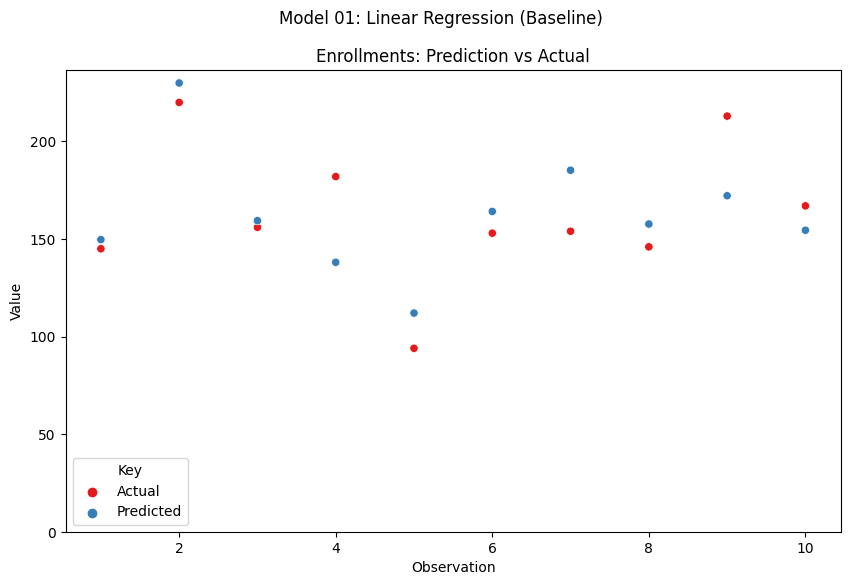

In [ ]:
# Assuming y_pred is the vector of predictions and y_test is the vector of actual values
predictions_df = pd.DataFrame({'Observation': range(1, len(y_test) + 1),
                               'Actual': y_test.values,
                               'Predicted': y_pred})

# Transforming the DataFrame for visualization
predictions_melted = predictions_df.melt(id_vars='Observation', var_name='Key', value_name='Value')

# Visualizing the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_melted, x='Observation', y='Value', hue='Key', palette='Set1')
plt.ylim(bottom=0)  # To expand the y-axis limits
plt.title('Enrollments: Prediction vs Actual')
plt.suptitle('Model 01: Linear Regression (Baseline)')
plt.show()


In [ ]:
# Adding a constant to X_train for the intercept term
X_train_const = sm.add_constant(X_train)

# Fitting the linear regression model using OLS
model_ols = sm.OLS(y_train, X_train_const).fit()

# Obtain the OLS model summary
model_summary = model_ols.summary()

# Convert the model results into a DataFrame
# Note: summary2().tables[1] is used to obtain only the coefficient table, which is typically what you want to convert into a DataFrame.
results_df = model_ols.summary2().tables[1]

# Sorting the DataFrame by p-value
results_df_sorted_by_p_value = results_df.sort_values(by='P>|t|')

# Displaying the sorted DataFrame
print(results_df_sorted_by_p_value)

                Coef.   Std.Err.         t     P>|t|     [0.025      0.975]
Clicks      -0.629156   0.148329 -4.241618  0.000248  -0.934051   -0.324261
Pageviews    0.058909   0.015434  3.816825  0.000752   0.027184    0.090634
Experiment -18.705964   8.081916 -2.314546  0.028798 -35.318581   -2.093347
const       97.644729  85.882763  1.136954  0.265928 -78.889818  274.179277
DOW_Thu    -14.025768  16.980194 -0.826008  0.416315 -48.929056   20.877520
DOW_Mon      9.564560  22.238695  0.430086  0.670677 -36.147732   55.276851
DOW_Sat     -8.147498  19.949169 -0.408413  0.686315 -49.153602   32.858607
DOW_Wed      7.068692  17.985594  0.393020  0.697509 -29.901226   44.038610
DOW_Sun     -1.963388  17.078679 -0.114961  0.909359 -37.069116   33.142340
DOW_Tue     -0.891869  19.729894 -0.045204  0.964290 -41.447247   39.663509


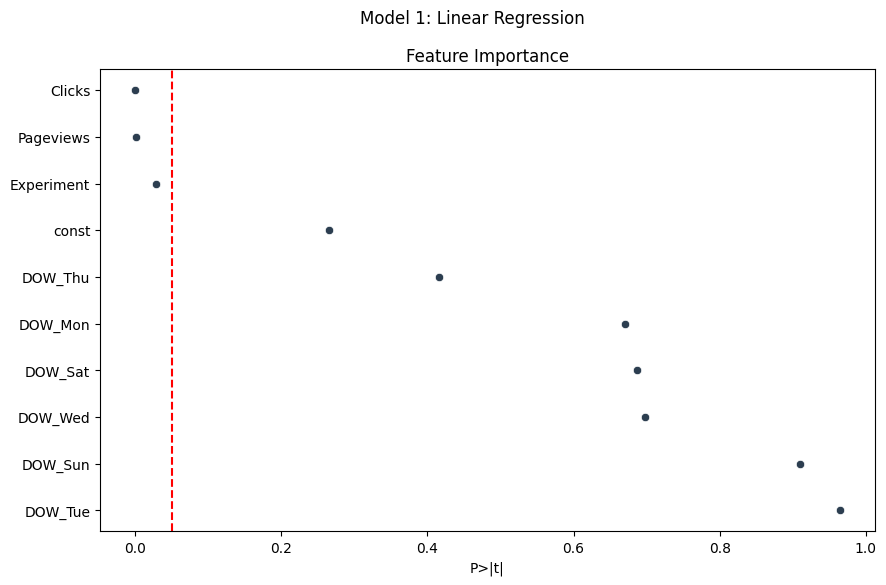

In [ ]:
# Feature Importance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df_sorted_by_p_value, x='P>|t|', y=results_df_sorted_by_p_value.index, color='#2C3E50')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.title('Feature Importance')
plt.suptitle('Model 1: Linear Regression ')
plt.show()


**Decision Tree**

In [ ]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],  # Tree depths to try
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
}

# Create the decision tree model with grid search
decision_tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model found by GridSearchCV
best_tree_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_tree_model.predict(X_test)

# Calculate metrics with the best model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Results
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")

# Show the best parameters found
print("Best parameters found:", grid_search.best_params_)

RMSE: 35.8068095671593
R2: -0.09303291677647985
MAE: 29.292500000000008
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}


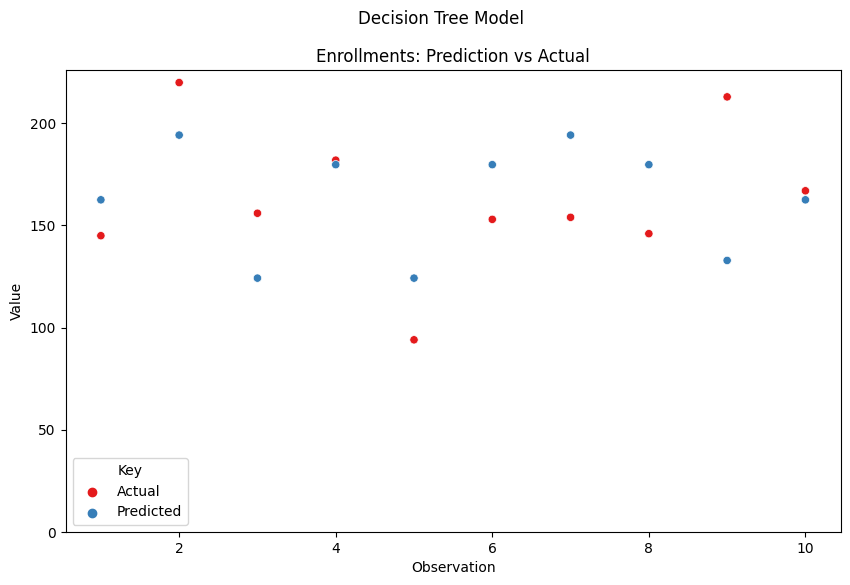

In [ ]:
# We create a DataFrame with the observations, the actual and the predicted values
predictions_df = pd.DataFrame({'Observation': range(1, len(y_test) + 1),
                               'Actual': y_test,
                               'Predicted': y_pred})

# We transform the DataFrame for visualization, melting the data into a long format
predictions_melted = predictions_df.melt(id_vars='Observation', var_name='Key', value_name='Value')

# We visualize the data using seaborn for a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_melted, x='Observation', y='Value', hue='Key', palette='Set1')
plt.ylim(bottom=0)  # This expands the y-axis limits if needed
plt.title('Enrollments: Prediction vs Actual')
plt.suptitle('Decision Tree Model')
plt.show()

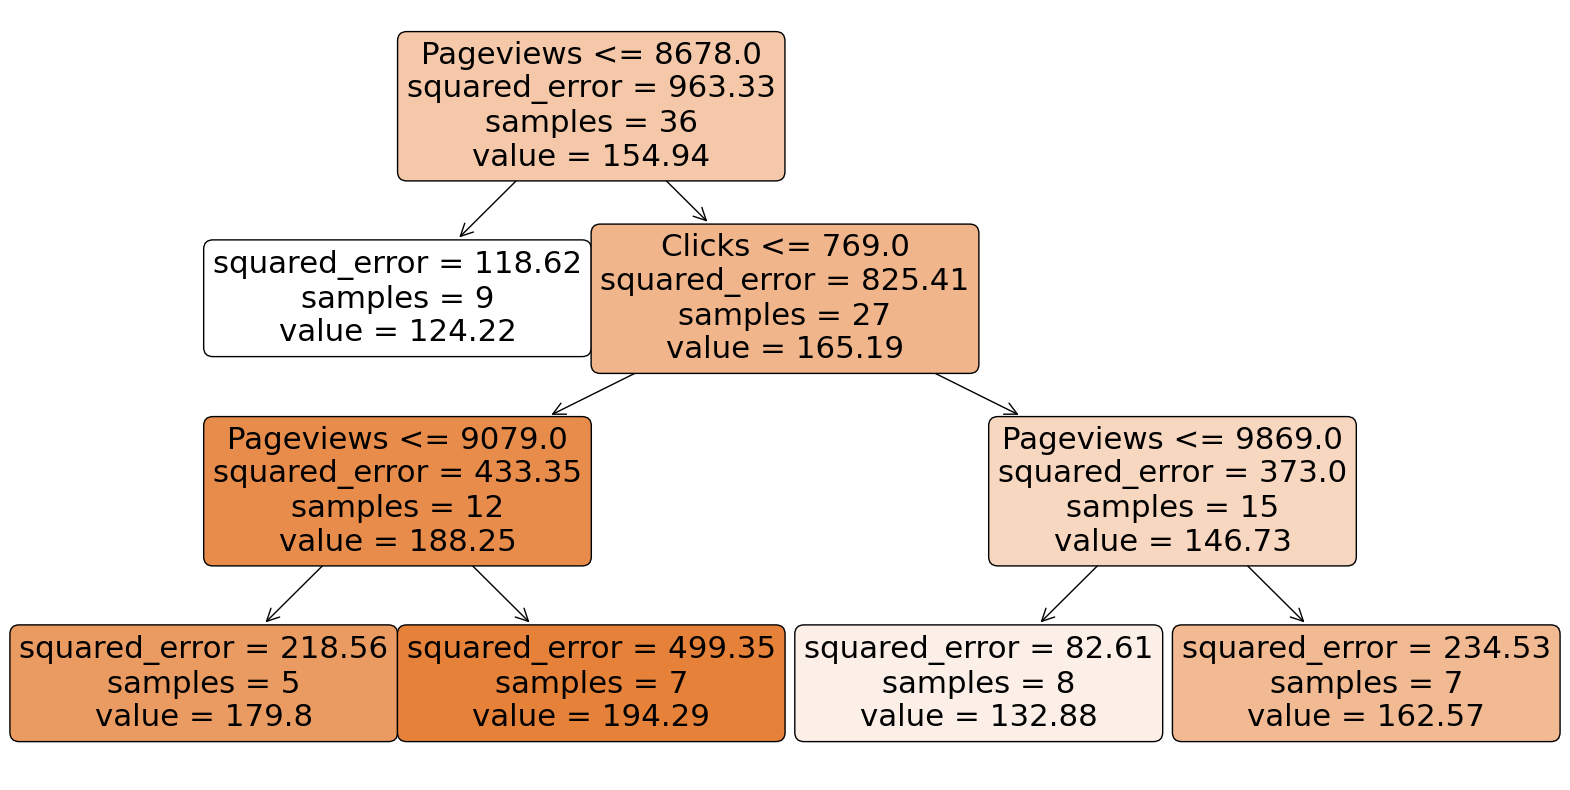

In [ ]:
# Visualize the top of the decision tree
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(best_tree_model,
          filled=True,
          feature_names=X_train.columns,
          class_names=['Not enrolled', 'Enrolled'],
          rounded=True,
          proportion=False,
          precision=2,
          max_depth=3)  # Limit the depth of the tree shown
plt.show()


**Model 3: XGBoost**

In [ ]:
# Define the model
xgb_reg = XGBRegressor(objective='reg:squarederror')

xgb_reg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_reg.predict(X_test)

# Calculating the metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")




RMSE: 23.00398950413907
R2: 0.548863143131679
MAE: 18.834664154052735


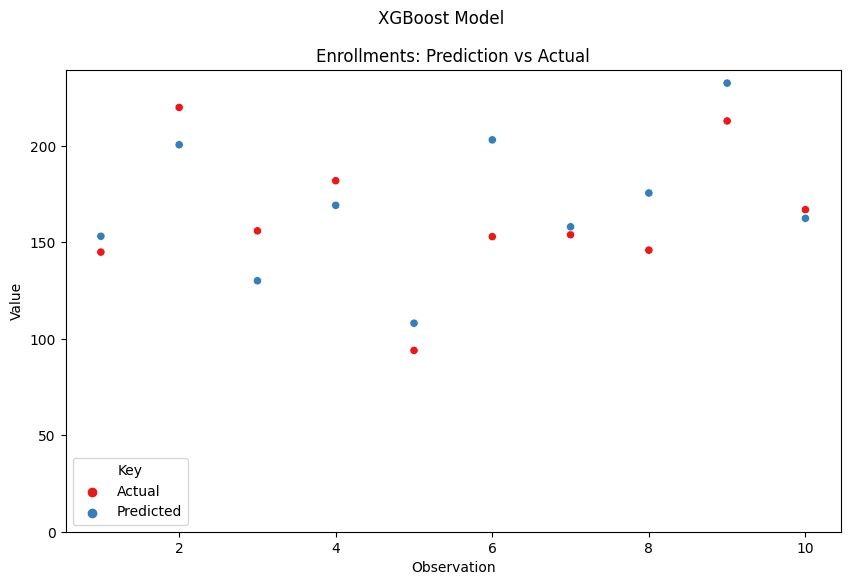

In [ ]:
# We create a DataFrame with the observations, the actual and the predicted values
predictions_df = pd.DataFrame({'Observation': range(1, len(y_test) + 1),
                               'Actual': y_test,
                               'Predicted': y_pred})

# We transform the DataFrame for visualization, melting the data into a long format
predictions_melted = predictions_df.melt(id_vars='Observation', var_name='Key', value_name='Value')

# We visualize the data using seaborn for a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_melted, x='Observation', y='Value', hue='Key', palette='Set1')
plt.ylim(bottom=0)  # This expands the y-axis limits if needed
plt.title('Enrollments: Prediction vs Actual')
plt.suptitle('XGBoost Model')
plt.show()